In [1]:
import random
import sys
import os
import json
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import torch
import torch.nn as nn
import torch.nn.functional as F

from glob import glob
from typing import List, Mapping, Tuple, Optional, Any
from collections import OrderedDict
from tqdm.notebook import tqdm
from torch.nn.modules.loss import _WeightedLoss
from catalyst import dl
from catalyst.dl import utils
from catalyst.dl import SupervisedRunner
from catalyst.contrib.nn.optimizers import RAdam, Lookahead, Adam
from catalyst.dl.callbacks import OptimizerCallback, EarlyStoppingCallback, SchedulerCallback, CriterionCallback, CheckpointCallback
from ranger_adabelief import RangerAdaBelief
from adabelief_pytorch import AdaBelief

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, KFold
from matplotlib import pyplot as plt

from basic_utils.data import slice_sequances, anton_slicer
from basic_utils.metric import map_per_set, map_per_image, mapk
from nn_utils.swa import avarage_weights
from nn_utils.callbacks import MAP5Callback, CinemaMAP5Callback
from nn_utils.losses import SmoothCrossEntropyLoss

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'
print(f'Cur device : {DEVICE}')

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    torch.manual_seed(seed_value)    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(1234)

Cur device : cuda


In [3]:
BS = 2048
SEQ_LEN = 30
EXP_NAME = '2layerlstm_antonseqs_2048bs_40seqlen_rmsprop_byloss_alladdembs_textemb_dateembs_fixedmetric_correctval_5WeightedBCE_10folds_2twiceloss'

In [4]:
#!rm ../logdirs/2layerlstm_antonseqs_2048bs_40seqlen_adam_byloss_alladdembs_textemb_dateembs_fixedmetric_correctval_5WeightedBCE_10folds_2twiceloss -rf

## Load data

In [5]:
movies_ts = pd.read_csv('/ssd_data/cinema_hack/movies_dataset_10 months.csv')
movies_ts['ts'] = pd.to_datetime(movies_ts['ts'])
movies_ts = movies_ts.sort_values('ts').reset_index(drop=True)

In [6]:
movies_ts['day_of_week'] = movies_ts['ts'].apply(lambda x: x.dayofweek)
movies_ts['month'] = movies_ts['ts'].apply(lambda x: x.month)
movies_ts['day'] = movies_ts['ts'].apply(lambda x: x.day)
movies_ts['hour'] = movies_ts['ts'].apply(lambda x: x.hour)
movies_ts['year'] = movies_ts['ts'].apply(lambda x: x.year)

t_features = ['day_of_week', 'month', 'day', 'hour', 'year']
for f in t_features:
    movies_ts[f] = preprocessing.LabelEncoder().fit_transform(movies_ts[f]) + 1

In [7]:
movies_ts

ts               user_id  movie_id  episode_id  \
0      2019-10-01 00:01:31   6582736606368231689     15391       81786   
1      2019-10-01 00:01:38    750594023898082561     17539      104006   
2      2019-10-01 00:01:57   2110694416164715906     11324           0   
3      2019-10-01 00:02:41  16763157513451692176     15498           0   
4      2019-10-01 00:03:17  15301363348200942035     11195           0   
...                    ...                   ...       ...         ...   
346403 2020-07-31 23:57:10    165634544827320948     11275           0   
346404 2020-07-31 23:57:31  16733346299848810533     20249           0   
346405 2020-07-31 23:57:49  17225429026700963251     16469       95135   
346406 2020-07-31 23:57:57   3362287430355034673     17756           0   
346407 2020-07-31 23:57:57   5670308344059159405     18943           0   

        day_of_week  month  day  hour  year  
0                 2      8    1     1     1  
1                 2      8    1     1     1  
2                 2      8    1     1     1  
3                 2      8    1     1     1  
4                 2      8    1     1     1  
...             ...    ...  ...   ...   ...  
346403            5      7   31    24     2  
346404            5      7   31    24     2  
346405            5      7   31    24     2  
346406            5      7   31    24     2  
346407            5      7   31    24     2  

[346408 rows x 9 columns]

In [8]:
sample_submission = pd.read_csv('/ssd_data/cinema_hack/submission.csv')

sample_submission['movie_id'] = sample_submission[' movie_id']
sample_submission = sample_submission.drop(columns=' movie_id')

In [9]:
with open("../add_data/ActorEmbed.json", "r") as read_file:
    actor_emb = json.load(read_file)
    actor_emb = {int(k):torch.Tensor(v) for k,v in actor_emb.items()}
    
with open("../add_data/DirectorEmbed.json", "r") as read_file:
    director_emb = json.load(read_file)
    director_emb = {int(k):torch.Tensor(v) for k,v in director_emb.items()}
    
with open("../add_data/GenreEmbed.json", "r") as read_file:
    genre_emb = json.load(read_file)
    genre_emb = {int(k):torch.Tensor(v) for k,v in genre_emb.items()}
    
with open("../add_data/ratingembed.json", "r") as read_file:
    rate_emb = json.load(read_file)
    rate_emb = {int(k):torch.Tensor(v) for k,v in rate_emb.items()}
    
with open("../add_data/TextEmbed.json", "r") as read_file:
    text_emb = json.load(read_file)
    text_emb = {int(k):torch.Tensor(v) for k,v in text_emb.items()}

In [10]:
missed_movies = set(movies_ts['movie_id']) - set(list(map(int, actor_emb.keys())))
for el in missed_movies:
    actor_emb[el] = torch.zeros_like(actor_emb[1])
    director_emb[el] = torch.zeros_like(director_emb[1])
    genre_emb[el] = torch.zeros_like(genre_emb[1])
    rate_emb[el] = torch.zeros_like(rate_emb[1])
    text_emb[el] = torch.zeros_like(text_emb[1])

In [11]:
movies_df = pd.read_csv('/ssd_data/cinema_hack/movies_database.csv')

In [12]:
def get_seq_apply(input):
    return list(input[['movie_id']+t_features].values)

## Prepare data

In [13]:
le_film_id = preprocessing.LabelEncoder()

# Increase train index for zero padding
movies_ts['movie_id'] = le_film_id.fit_transform(movies_ts['movie_id']) + 1

In [14]:
#sequences = movies_ts.groupby('user_id')['movie_id'].apply(list)
sequences = movies_ts.groupby('user_id').apply(get_seq_apply)

In [15]:
sequences2use = sequences[sequences.apply(len) >= 10]

le_classes = le_film_id.classes_

In [16]:
GENRE_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, genre_emb[0].shape[0]))
DIRECTOR_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, director_emb[0].shape[0]))
ACTOR_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, actor_emb[0].shape[0]))
RATE_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, rate_emb[0].shape[0]))
TEXT_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, text_emb[0].shape[0]))

In [17]:
for i in range(le_classes.shape[0]):
    GENRE_EMB[i+1] = genre_emb[le_classes[i]]
    DIRECTOR_EMB[i+1] = director_emb[le_classes[i]]
    ACTOR_EMB[i+1] = actor_emb[le_classes[i]]
    RATE_EMB[i+1] = rate_emb[le_classes[i]]
    TEXT_EMB[i+1] = text_emb[le_classes[i]]

In [18]:
TEXT_EMB.shape, RATE_EMB.shape

(torch.Size([4844, 768]), torch.Size([4844, 11]))

In [19]:
maxlen = SEQ_LEN # Length of sequences in X
X = []
y = []

def slice_sequence(seq, num_slices):
    for i in range(1, num_slices):
        X.append(seq[-(i+maxlen+4): -(i+4)])
        if i == 1:
            temp_y = seq[-(i+4):]
        else:
            temp_y = seq[-(i+4):-(i-1)]
        y.append([el[0] for el in temp_y])
        
for seq in sequences2use:
    if len(seq) <= 5+5:
        slice_sequence(seq, 2)
    elif len(seq) <= 6+5:
        slice_sequence(seq, 3)
    elif len(seq) <= 8+5:
        slice_sequence(seq, 4)
    elif len(seq) <= 12+5:
        slice_sequence(seq, 6)
    elif len(seq) <= 16+5:
        slice_sequence(seq, 8)
    elif len(seq) <= 20+5:
        slice_sequence(seq, 11)
    elif len(seq) <= 26+5:
        slice_sequence(seq, 16)
    elif len(seq) <= 30+5:
        slice_sequence(seq, 23)
    else:
        slice_sequence(seq, 30)

In [20]:
print(len(X), len(y))
print()
lens = [len(x) for x in X]
print(max(lens), min(lens), np.mean(lens), np.median(lens))

57151 57151

30 3 28.969466850973735 30.0


In [21]:
for i in range(len(X)):
    X[i] = [np.array([0,0,0,0,0,0])]*(maxlen - len(X[i])) + X[i]

In [22]:
sequences_test = sequences.apply(lambda x: x[-maxlen:])
sequences_test = sequences_test.apply(lambda x: [np.array([0,0,0,0,0,0]) for i in range(maxlen - len(x))] + x)

test_users_in_sequences = sorted(set(sequences_test.index) & set(sample_submission.user_id))

X_test = np.array(sequences_test[test_users_in_sequences].tolist())

In [23]:
X = np.array(X)
# Decrease target index 
y = np.array(y) - 1

## Train

In [24]:
'''
class BaselineModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddding = nn.Embedding(4843+1, 64, padding_idx=0)
        self.actor_layer = nn.Embedding(ACTOR_EMB.shape[0], ACTOR_EMB.shape[1], _weight=ACTOR_EMB)
        self.actor_layer.weight.requires_grad = False
        self.director_layer = nn.Embedding(DIRECTOR_EMB.shape[0], DIRECTOR_EMB.shape[1], _weight=DIRECTOR_EMB)
        self.director_layer.weight.requires_grad = False
        self.genre_layer = nn.Embedding(GENRE_EMB.shape[0], GENRE_EMB.shape[1], _weight=GENRE_EMB)
        self.genre_layer.weight.requires_grad = False
        
        self.emb_dropout = nn.Dropout(0.01)
        self.lstms = nn.LSTM(
            input_size=64 + ACTOR_EMB.shape[1] + DIRECTOR_EMB.shape[1] + GENRE_EMB.shape[1],
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(128, 4843)
        )
       
    def forward(self, x):
        x = torch.cat([
            self.embeddding(x), self.actor_layer(x), self.director_layer(x), self.genre_layer(x)
        ], dim=-1)
        x = self.emb_dropout(x)
        _, (hidden, _) = self.lstms(x)
        out = self.fc(hidden[-1])
        return out
'''

class BaselineModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddding = nn.Embedding(4843+1, 128, padding_idx=0)
        self.rate_layer = nn.Embedding(RATE_EMB.shape[0], RATE_EMB.shape[1], _weight=RATE_EMB)
        self.rate_layer.weight.requires_grad = False
        self.director_layer = nn.Embedding(DIRECTOR_EMB.shape[0], DIRECTOR_EMB.shape[1], _weight=DIRECTOR_EMB)
        self.director_layer.weight.requires_grad = False
        self.actor_layer = nn.Embedding(ACTOR_EMB.shape[0], ACTOR_EMB.shape[1], _weight=ACTOR_EMB)
        self.actor_layer.weight.requires_grad = False
        self.genre_layer = nn.Embedding(GENRE_EMB.shape[0], GENRE_EMB.shape[1], _weight=GENRE_EMB)
        self.genre_layer.weight.requires_grad = False
        
        self.text_layer = nn.Embedding(TEXT_EMB.shape[0], TEXT_EMB.shape[1], _weight=TEXT_EMB)
        self.text_layer.weight.requires_grad = False
        self.text_linear = nn.Linear(TEXT_EMB.shape[1], 64)
        
        self.day_emb = nn.Embedding(movies_ts.day.nunique() + 1, 8, padding_idx=0)
        self.dow_emb = nn.Embedding(movies_ts.day_of_week.nunique() + 1, 2, padding_idx=0)
        self.month_emb = nn.Embedding(movies_ts.month.nunique() + 1, 4, padding_idx=0)
        self.hour_emb = nn.Embedding(movies_ts.hour.nunique() + 1, 8, padding_idx=0)
        self.year_emb = nn.Embedding(movies_ts.year.nunique() + 1, 2, padding_idx=0)

        self.emb_dropout = nn.Dropout(0.01)
        self.lstm = nn.LSTM(
            input_size=128 + RATE_EMB.shape[1] + GENRE_EMB.shape[1] + DIRECTOR_EMB.shape[1] + ACTOR_EMB.shape[1] + 24 + 64,
            hidden_size=256,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        self.inter_drop = nn.Dropout(0.1)
        self.lstm_second = nn.LSTM(
            input_size=256,
            hidden_size=256,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(256 + 256, 4843)
        )
       
    def forward(self, x):
        text_emb = self.text_layer(x[:,:,0])
        text_emb = self.text_linear(text_emb)
        
        x = torch.cat([
            self.embeddding(x[:,:,0]), 
            self.rate_layer(x[:,:,0]), 
            self.genre_layer(x[:,:,0]), 
            self.director_layer(x[:,:,0]), 
            self.actor_layer(x[:,:,0]),
            self.day_emb(x[:,:,3]),
            self.dow_emb(x[:,:,1]),
            self.month_emb(x[:,:,2]),
            self.hour_emb(x[:,:,4]),
            self.year_emb(x[:,:,5]),
            text_emb
        ], dim=-1)
        #x = self.embeddding(x)
        x = self.emb_dropout(x)
        x, (lstm_hidden_1, _) = self.lstm(x)
        x = self.inter_drop(x)
        _, (lstm_hidden_2, _) = self.lstm_second(x)
        hidden = torch.cat((lstm_hidden_1[-1], lstm_hidden_2[-1]), dim=-1)
        out = self.fc(hidden)
        return out

In [25]:
class CinemaBCE(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()
        self.weight = torch.Tensor([1.0,0.9,0.8,0.7,0.6])[None,:,None]
        self.weight = self.weight.to(DEVICE)
        
    def forward(self, input, target):
        target = torch.nn.functional.one_hot(target, num_classes=le_classes.shape[0]).float()
        target = target * self.weight
        target = target.sum(1)
        return self.loss(input, target)
        

In [26]:
def train_function(
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    exp_name: str = EXP_NAME
):
    print(f"Train shapes: {X_train.shape, y_train.shape}")
    print(f"Test shapes: {X_val.shape, y_val.shape}")
    dataset_train = torch.utils.data.TensorDataset(
        X_train,
        y_train
    )
    dataloader_train = torch.utils.data.DataLoader(dataset_train, BS, shuffle=True, drop_last=True)

    dataset_val = torch.utils.data.TensorDataset(
        X_val,
        y_val
    )
    dataloader_val = torch.utils.data.DataLoader(dataset_val, BS)

    loaders = {'train':dataloader_train, 'valid': dataloader_val}
   
    model = BaselineModel().to(DEVICE)
    print(model)

    optimizer = torch.optim.RMSprop(model.parameters(), lr=2e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, mode='min')

    criterion =  CinemaBCE()#SmoothCrossEntropyLoss(smoothing=0.1)#nn.CrossEntropyLoss()

    callbacks =[
                CinemaMAP5Callback(),
                OptimizerCallback(metric_key="loss", accumulation_steps=1),
                EarlyStoppingCallback(patience=10, metric='loss', minimize=True),
                SchedulerCallback(mode='epoch', reduced_metric="loss"),
                CheckpointCallback(save_n_best=3)
            ]

    runner = SupervisedRunner()

    # Train 
    runner.train(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            loaders=loaders,
            logdir=exp_name,
            num_epochs=165,
            verbose=True,
            main_metric="loss",
            minimize_metric=True,
            callbacks=callbacks
        ) 
    
def inference_function(
    X_array: torch.Tensor,
    exp_name: str,
    return_logits: bool = False
):
    dataset = torch.utils.data.TensorDataset(
        X_array,
        torch.zeros_like(X_array)
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BS)
    
    runner = SupervisedRunner()
    prediction = runner.predict_loader(
        loader=dataloader, 
        model=BaselineModel().to(DEVICE), 
        resume=f'{exp_name}/checkpoints/best.pth'
    )
    prediction = torch.cat([b['logits'].detach().cpu() for b in prediction])
    if return_logits:
        prediction = prediction.numpy()
    else:
        prediction = torch.sort(-prediction, 1).indices[:,:5].numpy()
    
    return prediction

In [27]:
#!rm ../logdirs/antonlstm_anton_seqs_2048bs_30seqlen_adam_byloss_addembs_fixedmetric_correctval -rf

In [ ]:
skf = KFold(shuffle=True, random_state=1234, n_splits=10)
all_val_targets = []
all_val_preds = []
all_test_preds = []

for f_id, (train_index, test_index) in enumerate(skf.split(X)):
    print(f"Fold {f_id} started")
    
    train_X, train_y = X[train_index,:], y[train_index]
    val_X, val_y = X[test_index,:], y[test_index]
    
    
    train_function(
        torch.LongTensor(train_X),
        torch.LongTensor(train_y),
        torch.LongTensor(val_X),
        torch.LongTensor(val_y),
        f'../logdirs/{EXP_NAME}/fold_{f_id}'
    )
    
    
    avarage_weights(
            path_to_chkps=glob(f'../logdirs/{EXP_NAME}/fold_{f_id}/checkpoints/train.*_full.pth'),
            save_path=f'../logdirs/{EXP_NAME}/fold_{f_id}/checkpoints/swa_best.pth'
        )
        
    val_pred = inference_function(
        torch.LongTensor(val_X),
        f'../logdirs/{EXP_NAME}/fold_{f_id}'
    )
    val_pred = list(val_pred)
    val_target = list(val_y)
    fold_score = mapk(val_target, val_pred)
    print(f"Best score: {fold_score}")
    all_val_preds.append(val_pred)
    all_val_targets.append(val_target)
    
    all_test_preds.append(inference_function(
        torch.LongTensor(X_test),
        f'../logdirs/{EXP_NAME}/fold_{f_id}',
        return_logits=True
    ))
    

Fold 0 started
Train shapes: (torch.Size([51435, 30, 6]), torch.Size([51435, 5]))
Test shapes: (torch.Size([5716, 30, 6]), torch.Size([5716, 5]))
BaselineModel(
  (embeddding): Embedding(4844, 128, padding_idx=0)
  (rate_layer): Embedding(4844, 11)
  (director_layer): Embedding(4844, 64)
  (actor_layer): Embedding(4844, 64)
  (genre_layer): Embedding(4844, 8)
  (text_layer): Embedding(4844, 768)
  (text_linear): Linear(in_features=768, out_features=64, bias=True)
  (day_emb): Embedding(32, 8, padding_idx=0)
  (dow_emb): Embedding(8, 2, padding_idx=0)
  (month_emb): Embedding(11, 4, padding_idx=0)
  (hour_emb): Embedding(25, 8, padding_idx=0)
  (year_emb): Embedding(3, 2, padding_idx=0)
  (emb_dropout): Dropout(p=0.01, inplace=False)
  (lstm): LSTM(363, 256, batch_first=True)
  (inter_drop): Dropout(p=0.1, inplace=False)
  (lstm_second): LSTM(256, 256, batch_first=True)
  (fc): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=512, out_features=4843, bias=Tr

## Compute score and create submit

In [29]:
from itertools import chain
from scipy.special import softmax

In [30]:
scores = [mapk(t,p) for t,p in zip(all_val_targets, all_val_preds)]

 Mean score : 0.2249475644999705
 STD score : 0.004136062911309736


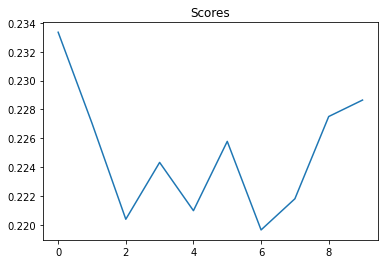

In [31]:
print(f" Mean score : {np.mean(scores)}")
print(f" STD score : {np.std(scores)}")

plt.title('Scores')
plt.plot(scores);

In [32]:
val_score = mapk(
    list(chain(*all_val_targets)), 
    list(chain(*all_val_preds))
)
print(f"OOF val score: {val_score}")

OOF val score: 0.22494771161776114


 Mean loss : -0.10808733951506332
 STD loss : 0.004766313408114338


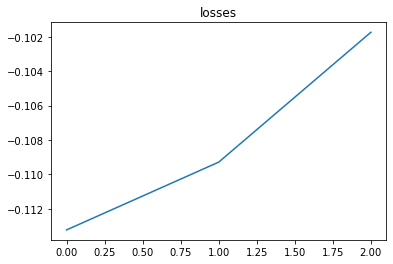

In [33]:
losses = [
    torch.load(f'../logdirs/{EXP_NAME}/fold_{idx}/checkpoints/best.pth', map_location='cpu')['valid_metrics']['loss']
    for idx in range(3)
]
val_loss = np.mean(losses)
print(f" Mean loss : {np.mean(losses)}")
print(f" STD loss : {np.std(losses)}")

plt.title('losses')
plt.plot(losses);

In [34]:
len(all_test_preds)

10

In [35]:
processed_test_preds = np.stack(all_test_preds, axis=0).mean(0)
print(processed_test_preds.min(), processed_test_preds.max())
processed_test_preds = np.argsort(-processed_test_preds)[:,:5]

-516.54236 2460.0977


In [36]:
le_film_id.classes_

array([    0,     1,     2, ..., 20324, 20325, 20326])

In [37]:
np.save(f'../test_preds/{EXP_NAME}.npy', np.array([
    all_test_preds,test_users_in_sequences, le_film_id.classes_
]))

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [38]:
final_processed_test_preds = [le_film_id.inverse_transform(row) for row in processed_test_preds]
final_processed_test_preds = [' '.join(map(lambda x: str(x), row)) for row in final_processed_test_preds]

In [39]:
sample_submission.index = sample_submission.user_id
sample_submission.loc[test_users_in_sequences, 'movie_id'] = final_processed_test_preds

In [40]:
sample_submission

user_id                       movie_id
user_id                                                                  
16975709365084587137  16975709365084587137    17729 3819 16026 8894 19485
10225505309438393880  10225505309438393880   18943 7347 19853 10475 17014
337894458057354820      337894458057354820  16830 16996 19650 19044 20118
16389753737490268206  16389753737490268206  17909 18548 16372 17757 18308
12377183607123393787  12377183607123393787  18943 11019 18823 18531 18883
...                                    ...                            ...
16073255054457636768  16073255054457636768   18943 15489 7347 18078 13378
18217982949448186449  18217982949448186449  18943 17014 19853 16238 10475
8493046014808115881    8493046014808115881   18746 8973 17571 19677 18943
6524731807859816855    6524731807859816855  15397 19287 15541 18943 13378
17611799088817908833  17611799088817908833  18943 16238 18078 10475 17014

[1695 rows x 2 columns]

In [41]:
EXP_NAME

'2layerlstm_antonseqs_2048bs_40seqlen_rmsprop_byloss_alladdembs_textemb_dateembs_fixedmetric_correctval_5WeightedBCE_10folds_2twiceloss'

In [42]:
sample_submission.to_csv(f'../subs/{EXP_NAME}_fold_blend.csv', index=False)

In [43]:
results = pd.read_csv('../exp_results.csv')
results

name     score      loss
0   antonlstm_anton_seqs_2048bs_30seqlen_rmsprop_b...  0.204648  6.030000
1   antonlstm_anton_seqs_2048bs_30seqlen_adam_bylo...  0.204867  5.998311
2   antonlstm_anton_seqs_2048bs_30seqlen_adam_bylo...  0.206739  5.956410
3   biggerlstm_anton_seqs_2048bs_30seqlen_adam_byl...  0.183482  6.194156
4   biggerlstm_anton_seqs_2048bs_50seqlen_rmsprop_...  0.095208  5.895552
5   cnn_antonseqs_2048bs_100seqlen_adam_byloss_fix...  0.050939  6.152246
6   antonlsrm_antonseqs_2048bs_30seqlen_adam_bylos...  0.053155  5.940439
7   cnnbigkernel_antonseqs_2048bs_100seqlen_adam_b...  0.054607  6.130779
8   cnnbigkernel_antonseqs_2048bs_100seqlen_adam_b...  0.068898  6.111183
9   antonlsrm_antonseqs_2048bs_30seqlen_adam_byCMA...  0.057620  5.871543
10  antonlsrm_antonseqs_2048bs_30seqlen_rmsprop_by...  0.110714  9.697514
11  2layerlstm_antonseqs_2048bs_30seqlen_adam_bylo...  0.212996  5.943749
12  2layerlstm_antonseqs_2048bs_30seqlen_rmsprop_b...  0.207915  6.044651
13  2layerlstm_antonseqs_2048bs_30seqlen_rmsprop_b...  0.216039  6.314783
14  simplelstm_antonseqs_2048bs_40seqlen_rmsprop_b...  0.231454  6.249322
15  simplelstm_antonseqs_2048bs_40seqlen_rmsprop_b...  0.231586  6.134151
16  simplelstm_antonseqs_2048bs_40seqlen_rmsprop_b...  0.213354  6.240834
17  simplelstm_antonseqs_2048bs_40seqlen_rmsprop_b...  0.210221 -0.047717

In [44]:
results = results.append({
    'name':EXP_NAME,
    'score':val_score,
    'loss': val_loss
}, ignore_index=True)

In [45]:
results

name     score      loss
0   antonlstm_anton_seqs_2048bs_30seqlen_rmsprop_b...  0.204648  6.030000
1   antonlstm_anton_seqs_2048bs_30seqlen_adam_bylo...  0.204867  5.998311
2   antonlstm_anton_seqs_2048bs_30seqlen_adam_bylo...  0.206739  5.956410
3   biggerlstm_anton_seqs_2048bs_30seqlen_adam_byl...  0.183482  6.194156
4   biggerlstm_anton_seqs_2048bs_50seqlen_rmsprop_...  0.095208  5.895552
5   cnn_antonseqs_2048bs_100seqlen_adam_byloss_fix...  0.050939  6.152246
6   antonlsrm_antonseqs_2048bs_30seqlen_adam_bylos...  0.053155  5.940439
7   cnnbigkernel_antonseqs_2048bs_100seqlen_adam_b...  0.054607  6.130779
8   cnnbigkernel_antonseqs_2048bs_100seqlen_adam_b...  0.068898  6.111183
9   antonlsrm_antonseqs_2048bs_30seqlen_adam_byCMA...  0.057620  5.871543
10  antonlsrm_antonseqs_2048bs_30seqlen_rmsprop_by...  0.110714  9.697514
11  2layerlstm_antonseqs_2048bs_30seqlen_adam_bylo...  0.212996  5.943749
12  2layerlstm_antonseqs_2048bs_30seqlen_rmsprop_b...  0.207915  6.044651
13  2layerlstm_antonseqs_2048bs_30seqlen_rmsprop_b...  0.216039  6.314783
14  simplelstm_antonseqs_2048bs_40seqlen_rmsprop_b...  0.231454  6.249322
15  simplelstm_antonseqs_2048bs_40seqlen_rmsprop_b...  0.231586  6.134151
16  simplelstm_antonseqs_2048bs_40seqlen_rmsprop_b...  0.213354  6.240834
17  simplelstm_antonseqs_2048bs_40seqlen_rmsprop_b...  0.210221 -0.047717
18  2layerlstm_antonseqs_2048bs_40seqlen_rmsprop_b...  0.224948 -0.108087

In [46]:
results.to_csv('../exp_results.csv', index=False)